In [1]:
import torch
import mytorch
import mytorch.math as math
from matplotlib import pyplot as plt

In [1]:
class so3:
    def __init__(self, n_iter) -> None:
        x = torch.zeros(3,3,3,dtype=torch.double)
        x[0,2,1] = 1
        x[0,1,2] = -1
        x[1,0,2] = 1
        x[1,2,0] = -1
        x[2,1,0] = 1
        x[2,0,1] = -1
        self.al = x
        self.ad = x
        
        class element_impl(torch.autograd.Function):
            @staticmethod
            def forward(ctx:torch.autograd.function.FunctionCtx, w:torch.Tensor):
                al = self.algebra(w.detach())
                ad = self.adjoint(w.detach())
                y = torch.matrix_exp(al)
                ctx.save_for_backward(y,ad)
                return y
            
            @staticmethod
            def backward(ctx:torch.autograd.function.FunctionCtx, dy:torch.Tensor):
                y,ad = ctx.saved_tensors
                # r = torch.inverse(ad)@(torch.eye(3)-torch.matrix_exp(-ad))
                r = torch.eye(3)
                p = -ad/2
                for i in range(n_iter):
                    r += p
                    p = -p@ad/(i+3)
                dw = torch.einsum('...ij,...ik,...mn,mkj->...n',dy,y,r,self.al)
                return dw
            
        self._element = element_impl.apply
            
    def algebra(self,w):
        return torch.einsum('...i,ijk->...jk',w,self.al)
    
    def adjoint(self,w):
        return torch.einsum('...i,ijk->...jk',w,self.ad)
    
    def element(self,w):
        return self._element(w)


In [2]:
class LieGroup:
    def __init__(self) -> None:
        pass
    
    def _create_element_function(self, pade_order):
        assert pade_order>=2
        k = torch.arange(1,2*pade_order)
        c = -torch.cumprod(-1/k,-1)
        a,b = math.pade(c,pade_order,pade_order)
        
        class element_impl(torch.autograd.Function):
            @staticmethod
            def forward(ctx:torch.autograd.function.FunctionCtx, w:torch.Tensor):
                al = self.algebra(w.detach())
                y = torch.matrix_exp(al)
                ctx.save_for_backward(y,w.detach())
                return y
            
            @staticmethod
            def backward(ctx:torch.autograd.function.FunctionCtx, dy:torch.Tensor):
                y,w = ctx.saved_tensors
                ad = self.adjoint(w)
                
                p = a[0]*torch.eye(ad.shape[-1],device=dy.device)+a[1]*ad
                q = b[0]*torch.eye(ad.shape[-1],device=dy.device)+b[1]*ad
                r = ad
                for i in range(2,pade_order):
                    r = ad@r
                    p = p + a[i]*r
                    q = q + b[i]*r
                r = p@torch.inverse(q)
                dw = self.derivative(y, dy.conj())@r
                # dw = torch.einsum('...ij,...ik,...mn,mkj->...n',dy,y,r,self.al)
                return dw.conj()
            
        self.__element = element_impl.apply
            
    def algebra(self, w:torch.Tensor) -> torch.Tensor:
        raise NotImplementedError(f"LieGroup [{type(self).__name__}] is missing the required \"algebra\" function")
    
    def adjoint(self, w:torch.Tensor) -> torch.Tensor:
        raise NotImplementedError(f"LieGroup [{type(self).__name__}] is missing the required \"adjoint\" function")
    
    def derivative(self, y:torch.Tensor, dy:torch.Tensor) -> torch.Tensor:
        raise NotImplementedError(f"LieGroup [{type(self).__name__}] is missing the required \"derivative\" function")
    
    def element(self, w:torch.Tensor) -> torch.Tensor:
        return self.__element(w)


In [128]:
class SO3(LieGroup):
    def __init__(self) -> None:
        super().__init__()
        x = torch.zeros(3,3,3,dtype=torch.double)
        x[0,2,1] = 1
        x[0,1,2] = -1
        x[1,0,2] = 1
        x[1,2,0] = -1
        x[2,1,0] = 1
        x[2,0,1] = -1
        self.al = x
        self.ad = x
        self._create_element_function(13)  
            
    def algebra(self,w):
        return torch.einsum('...i,ijk->...jk',w,self.al)
    
    def adjoint(self,w):
        return torch.einsum('...i,ijk->...jk',w,self.ad)
    

In [117]:
class SO(LieGroup):
    def __init__(self, n:int, device=None) -> None:
        super().__init__()
        self.mdim = n
        self.gdim = n*(n-1)//2
        
        al = torch.zeros(self.gdim,self.mdim,self.mdim,dtype=torch.int)
        self.__index_al = torch.zeros(self.mdim,self.mdim,dtype=torch.long,device=device)
        k = 0
        for i in range(1,n):
            for j in range(i):
                al[k,i,j] = 1
                al[k,j,i] = -1
                self.__index_al[i,j] = k
                self.__index_al[j,i] = k
                k += 1
        
        self.__coef_al = al.sum(0).to(dtype=torch.double,device=device)
        self.__index_al = self.__index_al.flatten()
        
        ad = torch.zeros(self.gdim,self.gdim,self.gdim,dtype=torch.int)
        self.__index_ad = torch.zeros(self.gdim,self.gdim,dtype=torch.long,device=device)
        for i in range(self.gdim):
            ad[i] = self.vectorize(al[i]@al-al@al[i]).transpose(-2,-1)
            self.__index_ad[ad[i]!=0] = i
        
        self.__coef_ad = ad.sum(0).to(dtype=torch.double,device=device)
        self.__index_ad = self.__index_ad.flatten()
        
        self._create_element_function(9)
        
    def vectorize(self, x:torch.Tensor):
        idx0,idx1 = mytorch.count_to_index(torch.arange(self.mdim))
        return x[...,idx0,idx1]
            
    def algebra(self, w:torch.Tensor):
        return w[...,self.__index_al].unflatten(-1,(self.mdim,self.mdim))*self.__coef_al
        # return torch.einsum('...i,ijk->...jk',w,self.al)
    
    def adjoint(self, w:torch.Tensor):
        return w[...,self.__index_ad].unflatten(-1,(self.gdim,self.gdim))*self.__coef_ad
        # return torch.einsum('...i,ijk->...jk',w,self.ad)
    
    def derivative(self, y:torch.Tensor, dy:torch.Tensor):
        return torch.zeros(
            y.size()[:-2]+(self.gdim,), 
            dtype=y.dtype, 
            device=y.device
        ).index_add_(
            -1,
            self.__index_al,
            ((y.transpose(-2,-1)@dy)*self.__coef_al).flatten(-2)
        )
    

In [3]:
class GW(LieGroup):
    def __init__(self) -> None:
        super().__init__()
        self._create_element_function(9)
        
    def coef_al(self, dim:int, device=None):
        return -1j*(torch.abs(torch.arange(dim,device=device)[:,None]-torch.arange(dim,device=device)[None,:])<=(dim-1)//2)*\
            torch.arange(-dim//2+1,dim//2+1,device=device,dtype=torch.double)
    
    def index_al(self, dim:int, device=None):
        i = torch.nn.functional.pad(
                torch.arange(
                    dim,
                    device=device,
                    dtype=torch.long   
                ),
                [(dim-1)//2,(dim-1)//2]
            )
        return torch.as_strided(
            i,
            size=(dim,dim),
            stride=(i.stride(-1),i.stride(-1))
        ).flip([-2]).flatten()
            
    def algebra(self, w:torch.Tensor):
        dim = w.shape[-1]
        w_ = torch.nn.functional.pad(w,[(dim-1)//2,(dim-1)//2])
        return torch.as_strided(
            w_,
            size=w_.shape[:-1]+(dim,dim),
            stride=w_.stride()[:-1]+(w_.stride(-1),w_.stride(-1))
        ).flip([-2]).mul(
            -1j*torch.arange(-dim//2+1,dim//2+1,device=w.device,dtype=torch.double)
        )
        
    def adjoint(self, w:torch.Tensor):
        dim = w.shape[-1]
        w_ = torch.nn.functional.pad(w,[(dim-1)//2,(dim-1)//2])
        c = torch.arange(-3*(dim-1)//2,3*(dim-1)//2+1,device=w.device,dtype=torch.double)
        return torch.as_strided(
                w_,
                size=w_.shape[:-1]+(dim,dim),
                stride=w_.stride()[:-1]+(w_.stride(-1),w_.stride(-1))
            ).flip([-1])*\
            torch.as_strided(
                -1j*c,
                size=(dim,dim),
                stride=(c.stride(-1),2*c.stride(-1))
            ).flip([-1])
    
    def derivative(self, y:torch.Tensor, dy:torch.Tensor):
        return torch.zeros(
            y.size()[:-2]+(y.size(-1),), 
            dtype=y.dtype, 
            device=y.device
        ).index_add_(
            -1,
            self.index_al(y.size(-1), device=y.device),
            ((y.transpose(-2,-1)@dy)*self.coef_al(y.size(-1), device=y.device)).flatten(-2)
        )
    
    # def element(self, w: torch.Tensor) -> torch.Tensor:
    #     return torch.matrix_exp(self.algebra(w))
    

In [119]:
g = GW()
print(g.coef_al(7))
print(g.index_al(7))

tensor([[0.+3.j, 0.+2.j, 0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+3.j, 0.+2.j, 0.+1.j, 0.+0.j, 0.-1.j, 0.+0.j, 0.+0.j],
        [0.+3.j, 0.+2.j, 0.+1.j, 0.+0.j, 0.-1.j, 0.-2.j, 0.+0.j],
        [0.+3.j, 0.+2.j, 0.+1.j, 0.+0.j, 0.-1.j, 0.-2.j, 0.-3.j],
        [0.+0.j, 0.+2.j, 0.+1.j, 0.+0.j, 0.-1.j, 0.-2.j, 0.-3.j],
        [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j, 0.-1.j, 0.-2.j, 0.-3.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j, 0.-2.j, 0.-3.j]],
       dtype=torch.complex128)
tensor([3, 4, 5, 6, 0, 0, 0, 2, 3, 4, 5, 6, 0, 0, 1, 2, 3, 4, 5, 6, 0, 0, 1, 2,
        3, 4, 5, 6, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0, 1, 2,
        3])


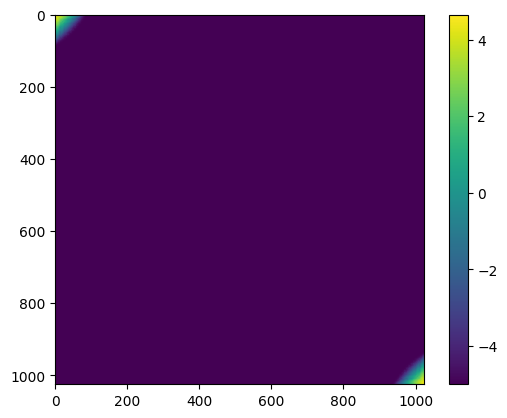

In [120]:
g = GW()
size = 513
iter = 8
w1 = torch.randn(size)+0j
w1[1:] = w1[1:] + 1j*torch.randn(size-1)
w1 = w1/torch.arange(1,size+1)**2*1e-2
w1[16:] = 0
w1 = torch.cat([w1[1:].flip([-1]).conj(),w1])
w1 = w1.to(dtype=torch.complex128)
L1 = g.algebra(w1)

w2 = torch.randn(size)+0j
w2[1:] = w2[1:] + 1j*torch.randn(size-1)
w2 = w2/torch.arange(1,size+1)**2*1e-2
w2[16:] = 0
w2 = torch.cat([w2[1:].flip([-1]).conj(),w2])
w2 = w2.to(dtype=torch.complex128)
L2 = g.algebra(w2)

CL = L2
for i in range(iter):
    CL = L1@CL-CL@L1

Ad = g.adjoint(w1)
w = w2
for i in range(iter):
    w = Ad@w
CA = g.algebra(w)

plt.imshow((CA-CL).abs().add(1e-5).log10())
plt.colorbar()
plt.show()

In [121]:
n = 16
device = 'cpu'
g = SO(n,device=device)
w = torch.randn(g.gdim,requires_grad=True,dtype=torch.double,device=device)*1e-2
torch.autograd.gradcheck(g.element,w)

GradcheckError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[-5.8966e-03, -9.9945e-01,  3.0979e-03,  ...,  1.5226e-05,
          1.1569e-05,  4.6796e-08],
        [-1.0280e-02, -3.2028e-03, -9.9955e-01,  ..., -1.9792e-05,
          1.8319e-05,  6.3222e-07],
        [ 6.0973e-07, -5.0663e-03,  3.0390e-03,  ..., -2.5842e-05,
         -6.0821e-06,  2.0206e-07],
        ...,
        [ 3.2169e-07, -1.5755e-05, -2.3154e-05,  ..., -5.0842e-03,
          1.2298e-02,  2.8855e-03],
        [-2.0595e-08, -1.4878e-05,  1.9309e-05,  ...,  9.9967e-01,
          2.2427e-03,  3.8410e-03],
        [-4.2927e-07, -1.1387e-05, -1.8292e-05,  ..., -2.2568e-03,
          9.9968e-01,  4.1756e-04]], dtype=torch.float64)
analytical:tensor([[-5.8969e-03, -9.9998e-01,  3.1804e-03,  ...,  4.6177e-05,
          3.4821e-05,  1.3579e-07],
        [-1.0282e-02, -3.1191e-03, -9.9995e-01,  ..., -5.9665e-05,
          5.3867e-05,  1.8906e-06],
        [ 1.8334e-06, -5.1242e-03,  2.9816e-03,  ..., -7.6937e-05,
         -1.8028e-05,  6.0946e-07],
        ...,
        [ 9.6899e-07, -4.7181e-05, -6.7861e-05,  ..., -5.1301e-03,
          1.2228e-02,  2.8861e-03],
        [-6.9706e-08, -4.4127e-05,  5.7611e-05,  ...,  9.9999e-01,
          2.2483e-03,  3.8414e-03],
        [-1.2943e-06, -3.4027e-05, -5.5952e-05,  ..., -2.2498e-03,
          1.0000e+00,  4.1845e-04]], dtype=torch.float64)


In [122]:
n = 33
device = 'cuda'
g = GW()
w = torch.randn(n,requires_grad=True,dtype=torch.double,device=device) +0j
w[1:] = w[1:] + 1j*torch.randn(n-1,requires_grad=True,dtype=torch.double,device=device)
w[1:] = w[1:]/torch.arange(1,n,dtype=torch.double,device=device)**2
w[4:] = 0
w = torch.cat([w[1:].flip([-1]).conj(),w])*1e-3

try:
    torch.autograd.gradcheck(g.element,w,atol=1e-2,rtol=1e-1)
except RuntimeError as e:
    print(e)

While considering the imaginary part of complex outputs only, Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]],
       device='cuda:0', dtype=torch.complex128)
analytical:tensor([[-1.2511e-34+5.3906e-34j, -9.5605e-36-8.5180e-36j,
         -6.6165e-38+5.7559e-39j,  ...,
          0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
          0.0000e+00-0.0000e+00j],
        [ 4.8671e-33-7.1404e-34j, -1.1773e-34+5.0727e-34j,
         -8.9865e-36-8.0065e-36j,  ...,
          0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
          0.0000e+00-0.0000e+00j],
        [ 3.3211e-31+2.5767e-

In [123]:
n = 16
g = SO(n)
w1 = torch.randn(g.gdim,dtype=torch.double)
w2 = torch.randn(g.gdim,dtype=torch.double)
l1 = g.algebra(w1)
l2 = g.algebra(w2)

c_al = l1@l2-l2@l1

ad = g.adjoint(w1)
w = ad@w2
c_ad = g.algebra(w)

torch.dist(c_al,c_ad)

tensor(1.4419e-14, dtype=torch.float64)

In [124]:
n = 35
batch = 256
dtype = torch.double
device = 'cuda'
g = SO(n,device=device)

KeyboardInterrupt: 

In [52]:
w = torch.randn(batch,g.gdim,requires_grad=True,dtype=dtype,device=device)
A = g.element(w)

x = torch.randn(batch,g.mdim,10,dtype=dtype,device=device)
y = torch.randn(batch,g.mdim,10,dtype=dtype,device=device)
loss = torch.dist(y,A@x)
loss.backward()
print(w.grad)

tensor([[-0.1089, -0.0238,  0.0203,  ..., -0.4617, -0.2534, -0.1915],
        [-0.8672,  0.3930, -0.1102,  ...,  0.0428,  0.2602, -0.9593],
        [ 0.5985,  0.1622,  0.1053,  ...,  0.1972,  0.2944, -0.2771],
        ...,
        [-0.3459, -0.1368, -0.4822,  ...,  0.7324,  0.0742,  0.0045],
        [-0.0965, -0.0478,  0.0599,  ..., -0.4932, -0.3087,  0.4541],
        [ 0.6555,  0.2391, -0.8157,  ..., -0.0915, -1.3080,  0.5998]],
       device='cuda:0', dtype=torch.float64)


In [5]:
n = 2049
batch = 256
device = 'cuda'
dtype = torch.complex128
g = GW()
w = torch.nn.Parameter(torch.zeros(n,dtype=dtype,device=device))
x = torch.randn(batch,2*n-1,10,dtype=dtype,device=device)
w_ = torch.randn(n,device=device,dtype=dtype)/torch.arange(1,n+1,device=device)**2*1e-3
A = g.element(torch.cat([w_[1:].flip([-1]).conj(),w_[:1].real+0j,w_[1:]]))
y = A@x
optimizer = torch.optim.Adam([w],lr=1e-4)

# w[1:] = w[1:] + 1j*torch.randn(n-1,requires_grad=True,dtype=torch.double,device=device)
# w[1:] = w[1:]/torch.arange(1,n,dtype=torch.double,device=device)
for i in range(1000):
    A = g.element(torch.cat([w[1:].flip([-1]).conj(),w[:1].real+0j,w[1:]]))
    loss = torch.dist(y,A@x)
    print(f'{loss}\r', end='')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()